### Import libraries that needed

In [15]:
import pandas as pd
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle

### Parameter values

In [16]:
PADDING_STYLE = 'post'
OOV_TOKEN = "<OOV>"
VOCAB_SIZE = 10000
EMBEDDING_DIM = 64

### Import datas (train.txt, test.txt, & val.txt)

In [17]:
!gdown --id 1_dVImkGNSGyNfhwyk-HvEAbhsgfllme5
!gdown --id 1_78dxOwwLGw1v2O8Ksj7RqpHzkEbnndQ
!gdown --id 1mZ7LHrcN_KzrxYektcnlBRzqBOlIOIL2

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1_dVImkGNSGyNfhwyk-HvEAbhsgfllme5
To: /content/test.txt
100% 207k/207k [00:00<00:00, 113MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1_78dxOwwLGw1v2O8Ksj7RqpHzkEbnndQ
To: /content/train.txt
100% 1.66M/1.66M [00:00<00:00, 201MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Access denied with the following 

### Read datas

In [18]:
df_train = pd.read_csv('train.txt', delimiter=';', header=None, names=['content','emotion'])
df_test = pd.read_csv('test.txt', delimiter=';', header=None, names=['content','emotion'])
df_val = pd.read_csv('val.txt', delimiter=';', header=None, names=['content','emotion'])

In [19]:
# See how dataframe looks alike
df_train

,content,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


### Preprocessing data (Non NLP)

In [20]:
# Checking for missing value
print(df_train.isnull().sum().sum())
print(df_test.isnull().sum().sum())
print(df_val.isnull().sum().sum())

0
0
0


In [21]:
# Checking for duplicated value
print(df_train[df_train.duplicated()])
print(df_test[df_test.duplicated()])
print(df_val[df_val.duplicated()])

                                                 content emotion
13846  i feel more adventurous willing to take risks ...     joy
Empty DataFrame
Columns: [content, emotion]
Index: []
Empty DataFrame
Columns: [content, emotion]
Index: []


In [22]:
# Remove duplicated data
df_train.drop_duplicates(inplace=True)
print(df_train[df_train.duplicated()])

Empty DataFrame
Columns: [content, emotion]
Index: []


In [23]:
# Cast from categorical data to numerical data
y_train = df_train.emotion.replace(['sadness','joy','fear','anger','love','surprise'],[0,1,2,3,4,5]).astype(np.float32)
y_test = df_test.emotion.replace(['sadness','joy','fear','anger','love','surprise'],[0,1,2,3,4,5]).astype(np.float32)
y_val = df_val.emotion.replace(['sadness','joy','fear','anger','love','surprise'],[0,1,2,3,4,5]).astype(np.float32)

### Preprocessing data (NLP)

In [24]:
# Tokenizing trianing data
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(df_train.content)

# Save tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [25]:
# Padding all datas
x_train_padded = pad_sequences(tokenizer.texts_to_sequences(df_train.content), padding=PADDING_STYLE)
x_test_padded = pad_sequences(tokenizer.texts_to_sequences(df_test.content), padding=PADDING_STYLE)
x_val_padded = pad_sequences(tokenizer.texts_to_sequences(df_val.content), padding=PADDING_STYLE)

### Creating and training model

In [26]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):

    if(logs.get('loss') < 0.1):

      # Stop if threshold is met
      print("\nLoss is lower than 0.1 so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [27]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=EMBEDDING_DIM,
                                                       return_sequences=True,
                                                       dropout=0.2,
                                                       recurrent_dropout=0.1,
                                                       kernel_initializer=tf.keras.initializers.he_normal())),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=EMBEDDING_DIM,
                                                       dropout=0.2,
                                                       recurrent_dropout=0.1,
                                                       kernel_initializer=tf.keras.initializers.he_normal())),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation='softmax')
])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          640000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                5

In [29]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy'])

In [30]:
NUM_EPOCHS = 20

# Train the model
history = model.fit(x_train_padded,y_train, epochs=NUM_EPOCHS, validation_data=(x_val_padded,y_val),callbacks=[callbacks])

Epoch 1/20
500/500 [==============================] - 401s 780ms/step - loss: 1.2415 - accuracy: 0.5308 - val_loss: 0.7440 - val_accuracy: 0.7055
Epoch 2/20
500/500 [==============================] - 389s 779ms/step - loss: 0.6015 - accuracy: 0.7691 - val_loss: 0.3858 - val_accuracy: 0.8715
Epoch 3/20
500/500 [==============================] - 389s 778ms/step - loss: 0.3248 - accuracy: 0.8962 - val_loss: 0.2893 - val_accuracy: 0.9105
Epoch 4/20
500/500 [==============================] - 389s 777ms/step - loss: 0.2025 - accuracy: 0.9372 - val_loss: 0.2864 - val_accuracy: 0.9115
Epoch 5/20
500/500 [==============================] - 390s 779ms/step - loss: 0.1582 - accuracy: 0.9523 - val_loss: 0.2478 - val_accuracy: 0.9175
Epoch 6/20
500/500 [==============================] - 388s 776ms/step - loss: 0.1276 - accuracy: 0.9597 - val_loss: 0.2605 - val_accuracy: 0.9200
Epoch 7/20
500/500 [==============================] - 389s 778ms/step - loss: 0.1000 - accuracy: 0.9682 - val_loss: 0.3467 -

### Evaluate test data

In [31]:
results = model.evaluate(x_test_padded, y_test, batch_size=128)
print("Test loss, test accuracy: ", results)

16/16 [==============================] - 1s 56ms/step - loss: 0.3189 - accuracy: 0.9235
Test loss, test accuracy:  [0.31891342997550964, 0.9235000014305115]


### Save model for deployment

In [32]:
model.save('model.h5')

### Plotting metrices

In [33]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

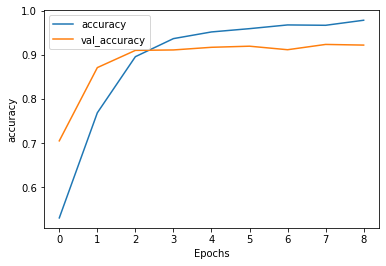

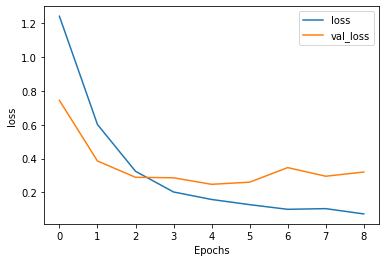

In [34]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

### Try predict

In [35]:
model = tf.keras.models.load_model('model.h5')

In [36]:
def mapping_emotion_code(emotion_numerical_code):
    if emotion_numerical_code == 0:
        return 'sadness'
    elif emotion_numerical_code == 1:
        return 'joy'
    elif emotion_numerical_code == 2:
        return 'fear'
    elif emotion_numerical_code == 3:
        return 'anger'
    elif emotion_numerical_code == 4:
        return 'love'
    elif emotion_numerical_code == 5:
        return 'surprise'

In [39]:
emotions_probability = model.predict(pad_sequences(tokenizer.texts_to_sequences(["I didn't think that my declaration of love would be accepted. I really feel very lucky, he put his heart to me. She is beautiful like an angel, millions of men want her, but in the end she anchored me. Thank god, you're really good."]), padding="post"))
predicted_emotion_numerical_code = np.argmax(emotions_probability)
predicted_emotion = mapping_emotion_code(predicted_emotion_numerical_code)
print(predicted_emotion)

joy
